In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = pd.read_csv("~/Desktop/Columbia 2024/Most Streamed Spotify Songs 2024.csv", encoding='latin1')
file.head(10)

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1
5,Lovin On Me,Lovin On Me,Jack Harlow,11/10/2023,USAT22311371,6,410.1,"670,665,438","105,892","175,421,034",...,"4,654",86.0,"17,167,254",152.0,"138,529,362","50,982","9,438,601","4,517,131",NaN,1
6,Beautiful Things,Beautiful Things,Benson Boone,1/18/2024,USWB12307016,7,407.2,"900,158,751","73,118","201,585,714",...,429,168.0,"48,197,850",154.0,"65,447,476","57,372",NaN,"9,990,302",NaN,0
7,Gata Only,Gata Only,FloyyMenor,2/2/2024,QZL382406049,8,375.8,"675,079,153","40,094","211,236,940",...,30,87.0,"33,245,595",53.0,"3,372,428","5,762",NaN,"6,063,523",NaN,1
8,Danza Kuduro - Cover,ýýýýýýýýýýýýýýýýýýýýý - ýýýýýýýýýýýýýýýýýý -,MUSIC LAB JPN,6/9/2024,TCJPA2463708,9,355.7,"1,653,018,119",1,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,BAND4BAND (feat. Lil Baby),BAND4BAND (feat. Lil Baby),Central Cee,5/23/2024,USSM12404354,10,330.6,"90,676,573","10,400","184,199,419",...,117,78.0,"10,800,098",92.0,"1,005,626",842,"3,679,709","666,302",NaN,1


In [3]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Track                       4600 non-null   object 
 1   Album Name                  4600 non-null   object 
 2   Artist                      4595 non-null   object 
 3   Release Date                4600 non-null   object 
 4   ISRC                        4600 non-null   object 
 5   All Time Rank               4600 non-null   object 
 6   Track Score                 4600 non-null   float64
 7   Spotify Streams             4487 non-null   object 
 8   Spotify Playlist Count      4530 non-null   object 
 9   Spotify Playlist Reach      4528 non-null   object 
 10  Spotify Popularity          3796 non-null   float64
 11  YouTube Views               4292 non-null   object 
 12  YouTube Likes               4285 non-null   object 
 13  TikTok Posts                3427 

In [4]:
file['Release Date'] = pd.to_datetime(file['Release Date'], format="%m/%d/%Y")
file

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,2024-04-26,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,2024-05-04,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,2024-03-19,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,2023-01-12,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,2024-05-31,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,For the Last Time,For the Last Time,$uicideboy$,2017-09-05,QM8DG1703420,"4,585",19.4,"305,049,963","65,770","5,103,054",...,NaN,2.0,"14,217",NaN,"20,104,066","13,184","50,633,006","656,337",NaN,1
4596,Dil Meri Na Sune,"Dil Meri Na Sune (From ""Genius"")",Atif Aslam,2018-07-27,INT101800122,"4,575",19.4,"52,282,360","4,602","1,449,767",...,NaN,1.0,927,NaN,NaN,NaN,NaN,"193,590",NaN,0
4597,Grace (feat. 42 Dugg),My Turn,Lil Baby,2020-02-28,USUG12000043,"4,571",19.4,"189,972,685","72,066","6,704,802",...,NaN,1.0,74,6.0,"84,426,740","28,999",NaN,"1,135,998",NaN,1
4598,Nashe Si Chadh Gayi,November Top 10 Songs,Arijit Singh,2016-11-08,INY091600067,"4,591",19.4,"145,467,020","14,037","7,387,064",...,NaN,NaN,NaN,7.0,"6,817,840",NaN,NaN,"448,292",NaN,0


In [5]:
file['Spotify Streams'] = file['Spotify Streams'].replace(",", "", regex=True)
file['Spotify Streams'] = pd.to_numeric(file['Spotify Streams'], downcast='integer', errors='coerce').fillna(0)
file['Spotify Streams'] = file['Spotify Streams'].astype(np.float64)
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Track                       4600 non-null   object        
 1   Album Name                  4600 non-null   object        
 2   Artist                      4595 non-null   object        
 3   Release Date                4600 non-null   datetime64[ns]
 4   ISRC                        4600 non-null   object        
 5   All Time Rank               4600 non-null   object        
 6   Track Score                 4600 non-null   float64       
 7   Spotify Streams             4600 non-null   float64       
 8   Spotify Playlist Count      4530 non-null   object        
 9   Spotify Playlist Reach      4528 non-null   object        
 10  Spotify Popularity          3796 non-null   float64       
 11  YouTube Views               4292 non-null   object      

In [6]:
candidates = [x for x in list(file.columns) if ('View' in x) or ('Like' in x) or ('Count' in x) or ('Rank' in x) or 'Stations' in x or 'Reach' in x or 'Stream' in x or 'Post' in x or 'Spin' in x]
for i in candidates:
    file[i] = file[i].replace(",", "", regex=True)
    file[i] = pd.to_numeric(file[i], downcast='integer', errors='coerce').fillna(0)
    file[i] = file[i].astype(np.float64)
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Track                       4600 non-null   object        
 1   Album Name                  4600 non-null   object        
 2   Artist                      4595 non-null   object        
 3   Release Date                4600 non-null   datetime64[ns]
 4   ISRC                        4600 non-null   object        
 5   All Time Rank               4600 non-null   float64       
 6   Track Score                 4600 non-null   float64       
 7   Spotify Streams             4600 non-null   float64       
 8   Spotify Playlist Count      4600 non-null   float64       
 9   Spotify Playlist Reach      4600 non-null   float64       
 10  Spotify Popularity          3796 non-null   float64       
 11  YouTube Views               4600 non-null   float64     

C:\Users\app\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


In [7]:
file['Explicit Track']=file['Explicit Track'].astype(bool)
file

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,2024-04-26,QM24S2402528,1.0,725.4,3.904709e+08,30716.0,196631588.0,...,684.0,62.0,17598718.0,114.0,18004655.0,22931.0,4818457.0,2669262.0,NaN,False
1,Not Like Us,Not Like Us,Kendrick Lamar,2024-05-04,USUG12400910,2.0,545.9,3.237039e+08,28113.0,174597137.0,...,3.0,67.0,10422430.0,111.0,7780028.0,28444.0,6623075.0,1118279.0,NaN,True
2,i like the way you kiss me,I like the way you kiss me,Artemas,2024-03-19,QZJ842400387,3.0,538.4,6.013093e+08,54331.0,211607669.0,...,536.0,136.0,36321847.0,172.0,5022621.0,5639.0,7208651.0,5285340.0,NaN,False
3,Flowers,Flowers - Single,Miley Cyrus,2023-01-12,USSM12209777,4.0,444.9,2.031281e+09,269802.0,136569078.0,...,2182.0,264.0,24684248.0,210.0,190260277.0,203384.0,0.0,11822942.0,NaN,False
4,Houdini,Houdini,Eminem,2024-05-31,USUG12403398,5.0,423.3,1.070349e+08,7223.0,151469874.0,...,1.0,82.0,17660624.0,105.0,4493884.0,7006.0,207179.0,457017.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,For the Last Time,For the Last Time,$uicideboy$,2017-09-05,QM8DG1703420,4585.0,19.4,3.050500e+08,65770.0,5103054.0,...,0.0,2.0,14217.0,0.0,20104066.0,13184.0,50633006.0,656337.0,NaN,True
4596,Dil Meri Na Sune,"Dil Meri Na Sune (From ""Genius"")",Atif Aslam,2018-07-27,INT101800122,4575.0,19.4,5.228236e+07,4602.0,1449767.0,...,0.0,1.0,927.0,0.0,0.0,0.0,0.0,193590.0,NaN,False
4597,Grace (feat. 42 Dugg),My Turn,Lil Baby,2020-02-28,USUG12000043,4571.0,19.4,1.899727e+08,72066.0,6704802.0,...,0.0,1.0,74.0,6.0,84426740.0,28999.0,0.0,1135998.0,NaN,True
4598,Nashe Si Chadh Gayi,November Top 10 Songs,Arijit Singh,2016-11-08,INY091600067,4591.0,19.4,1.454670e+08,14037.0,7387064.0,...,0.0,0.0,0.0,7.0,6817840.0,0.0,0.0,448292.0,NaN,False


In [8]:
file['Artist'].mode()

0           Drake
1    Taylor Swift
Name: Artist, dtype: object

In [9]:
drake = file[file['Artist'] == 'Drake']
taylor = file[file['Artist'] == 'Taylor Swift']

In [10]:
print(drake['All Time Rank'].mean())
print(taylor['All Time Rank'].mean())

1956.095238095238
2340.5079365079364


In [11]:
print(drake['Spotify Streams'].mean())
print(taylor['Spotify Streams'].mean())

554954882.1746032
547155097.8571428


In [12]:
print(drake['TikTok Posts'].mean())
print(taylor['TikTok Posts'].mean())

275845.5238095238
212674.52380952382


In [13]:
drake[drake['YouTube Playlist Reach'] == drake['YouTube Playlist Reach'].min()]

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
700,Slime You Out (feat. SZA),Slime You Out,Drake,2023-09-15,USUG12306064,696.0,57.9,2.021697e+08,54946.0,23594885.0,...,10.0,15.0,1651235.0,16.0,14611155.0,5724.0,6744659.0,791868.0,NaN,True
1912,Rich Baby Daddy (feat. Sexyy Red & SZA),For All The Dogs,Drake,2023-10-06,USUG12306108,1910.0,33.2,3.722481e+08,6868.0,1527625.0,...,0.0,1.0,31089.0,9.0,0.0,0.0,0.0,0.0,NaN,False
2092,Circo Loco,Her Loss,Drake,2022-11-04,USUG12208606,2077.0,31.6,2.014671e+08,74719.0,15970383.0,...,633.0,5.0,139795.0,8.0,31344634.0,4389.0,0.0,765958.0,NaN,True
2216,8am in Charlotte,For All The Dogs,Drake,2023-10-06,USUG12306082,2207.0,30.5,8.109323e+07,34004.0,4164888.0,...,1.0,3.0,135946.0,0.0,391257.0,932.0,0.0,385268.0,NaN,True
2542,Daylight,For All The Dogs,Drake,2023-10-06,USUG12306070,2521.0,28.2,7.841721e+07,26088.0,13353722.0,...,43.0,0.0,0.0,0.0,1294581.0,1122.0,2871573.0,152693.0,NaN,True
2544,Rich Flex,Her Loss,Drake,2022-11-03,USUG12208614,2520.0,28.2,8.118889e+08,5471.0,1026240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
2781,Calling For You (feat. 21 Savage),For All The Dogs,Drake,2023-10-06,USUG12306068,2758.0,26.7,7.426558e+07,23221.0,3122350.0,...,0.0,5.0,157363.0,0.0,795559.0,695.0,3639035.0,163845.0,NaN,True
3125,Jimmy Cook's (feat. 21 Savage),"Honestly, Nevermind",Drake,2022-06-17,USUG12204898,3097.0,24.8,9.714732e+08,8682.0,1452190.0,...,0.0,1.0,192.0,0.0,0.0,0.0,0.0,0.0,NaN,False
3428,Broke Boys,Her Loss,Drake,2022-11-04,USUG12208608,3399.0,23.5,1.432208e+08,57819.0,6493900.0,...,8.0,3.0,2699.0,12.0,11161976.0,2938.0,0.0,333934.0,NaN,True
4099,Too Good,Views,Drake,2016-04-29,USCM51600088,4074.0,21.1,1.052474e+09,126251.0,30938220.0,...,1.0,33.0,256100.0,22.0,363023813.0,129377.0,0.0,4577263.0,NaN,True


In [14]:
taylor[taylor['Shazam Counts'] == drake['Shazam Counts'].min()]

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
2484,So High School,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,Taylor Swift,2024-04-19,USUG12402544,2478.0,28.6,97601615.0,3397.0,13075013.0,...,0.0,0.0,0.0,50.0,1393596.0,1657.0,0.0,0.0,NaN,False
2524,Karma,Midnights (3am Edition),Taylor Swift,2022-10-21,USUG12205729,2510.0,28.3,777305444.0,2358.0,643308.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
2528,I Can Do It With a Broken Heart,THE TORTURED POETS DEPARTMENT,Taylor Swift,2024-04-18,USUG12401053,2525.0,28.2,250430303.0,648.0,818594.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,False
3451,Down Bad,THE TORTURED POETS DEPARTMENT,Taylor Swift,2024-04-18,USUG12401049,3437.0,23.3,210385853.0,418.0,1952536.0,...,0.0,9.0,51872.0,0.0,0.0,0.0,0.0,0.0,NaN,False
3909,The Black Dog,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,Taylor Swift,2024-04-19,USUG12401046,3892.0,21.6,81662552.0,2325.0,7529867.0,...,0.0,1.0,2842.0,21.0,1083938.0,699.0,0.0,0.0,NaN,True
4148,How Did It End?,THE TORTURED POETS DEPARTMENT: THE ANTHOLOGY,Taylor Swift,2024-04-19,USUG12402543,4140.0,20.9,72634553.0,2185.0,14312275.0,...,0.0,0.0,0.0,21.0,651838.0,393.0,0.0,0.0,NaN,False


In [15]:
file[file['Artist'] == 'Kendrick Lamar'].describe()

,Release Date,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,...,AirPlay Spins,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity
count,18,18.000000,18.000000,1.800000e+01,18.000000,1.800000e+01,17.000000,1.800000e+01,1.800000e+01,1.800000e+01,...,18.000000,18.000000,18.000000,1.800000e+01,18.000000,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,0.0
mean,2019-08-04 14:40:00,2155.611111,73.827778,6.784117e+08,126676.111111,3.851626e+07,74.411765,2.316807e+08,2.604950e+06,2.067633e+05,...,18841.055556,106.500000,31.277778,7.950082e+05,34.388889,1.728403e+08,120209.888889,1.732144e+06,2.737606e+06,NaN
min,2012-01-01 00:00:00,2.000000,19.700000,6.552039e+07,8933.000000,4.068649e+06,59.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,126.000000,0.000000,3.000000,1.598600e+04,6.000000,1.062564e+06,1174.000000,0.000000e+00,1.850090e+05,NaN
25%,2017-04-14 00:00:00,1221.500000,25.250000,2.123722e+08,63521.000000,1.066734e+07,71.000000,4.813574e+07,1.103518e+06,4.905750e+03,...,438.000000,7.750000,7.250000,1.077955e+05,22.000000,7.971942e+06,3171.500000,0.000000e+00,6.449915e+05,NaN
50%,2022-05-10 12:00:00,2175.500000,30.750000,3.753202e+08,92388.000000,2.377430e+07,74.000000,1.024606e+08,1.988860e+06,3.725800e+04,...,6095.500000,26.500000,24.000000,1.825615e+05,25.500000,2.371393e+07,17075.000000,0.000000e+00,1.310790e+06,NaN
75%,2022-05-13 00:00:00,3020.000000,42.850000,1.050746e+09,184874.500000,5.851729e+07,79.000000,3.259470e+08,3.378568e+06,1.030450e+05,...,33868.750000,73.500000,44.500000,3.877760e+05,37.000000,3.148920e+08,132828.250000,3.649545e+06,5.021750e+06,NaN
max,2024-05-04 00:00:00,4470.000000,545.900000,2.226870e+09,352198.000000,1.745971e+08,92.000000,1.281355e+09,1.155126e+07,1.180701e+06,...,84979.000000,692.000000,111.000000,1.042243e+07,111.000000,6.657421e+08,753880.000000,8.141454e+06,8.746447e+06,NaN
std,NaN,1415.624541,125.923169,6.327132e+08,98387.670723,4.151857e+07,7.984820,3.157743e+08,2.634959e+06,3.883873e+05,...,26236.550346,211.238714,29.381478,2.409684e+06,27.685500,2.191433e+08,203309.977812,2.799968e+06,2.842897e+06,NaN


In [16]:
for i in file['Artist'].value_counts()[:5].index.tolist():
    print(i, file[file['Artist'] == i].describe(), sep='\n')

Drake
                        Release Date  All Time Rank  Track Score  \
count                             63      63.000000    63.000000   
mean   2021-04-01 15:37:08.571428608    1956.095238    45.580952   
min              2011-07-22 00:00:00     154.000000    20.100000   
25%              2020-04-17 00:00:00     736.000000    24.650000   
50%              2022-11-03 00:00:00    1910.000000    33.200000   
75%              2023-10-06 00:00:00    3129.000000    56.500000   
max              2024-05-03 00:00:00    4358.000000   122.700000   
std                              NaN    1320.520458    28.021742   

       Spotify Streams  Spotify Playlist Count  Spotify Playlist Reach  \
count     6.300000e+01               63.000000            6.300000e+01   
mean      5.549549e+08           102684.634921            2.708422e+07   
min       0.000000e+00               35.000000            3.015000e+03   
25%       1.454549e+08            30426.500000            8.478010e+06   
50%       3

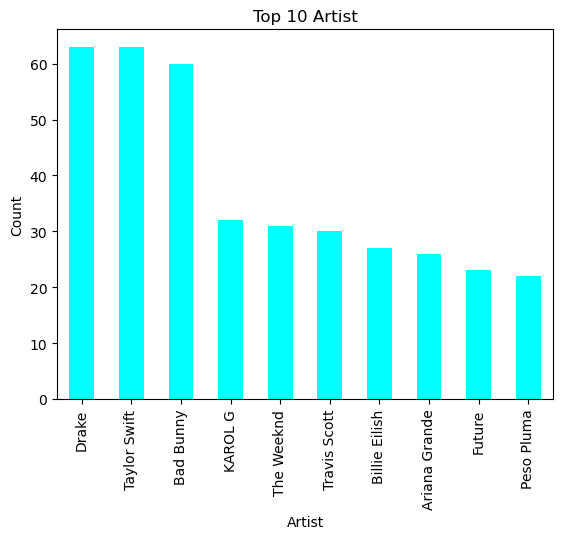

In [17]:
top10 = file['Artist'].value_counts().head(10)
top10.plot(kind = 'bar', color = 'cyan')
plt.title('Top 10 Artist')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.show()

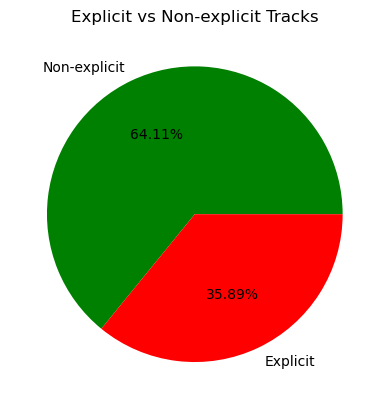

In [18]:
explicit_counts = file['Explicit Track'].value_counts()
plt.pie(explicit_counts, labels=['Non-explicit', 'Explicit'], autopct='%1.2f%%', colors=['green', 'red'])
plt.title('Explicit vs Non-explicit Tracks')
plt.show()

<Axes: xlabel='Year', ylabel='Count'>

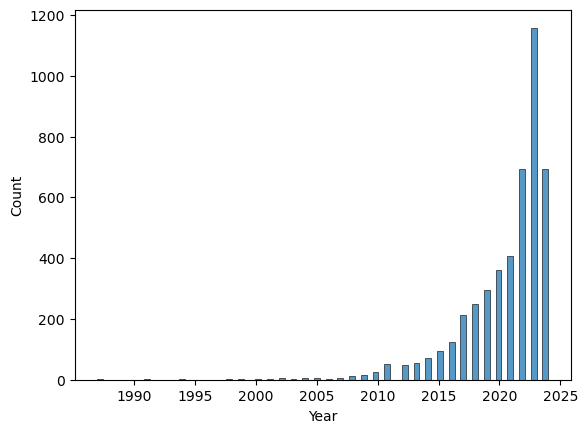

In [19]:
file['Year'] = file['Release Date'].dt.year
sns.histplot(data=file, x="Year")

<Axes: xlabel='Year', ylabel='Count'>

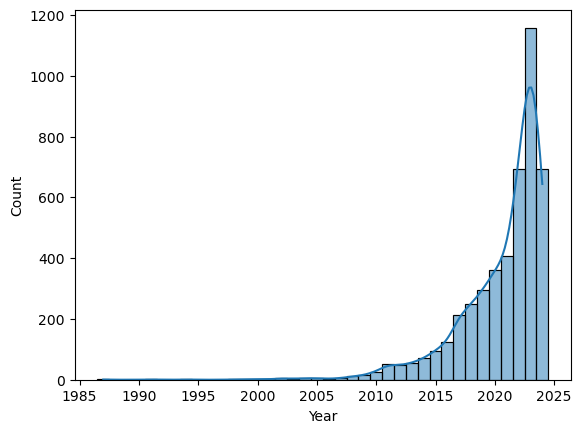

In [20]:
sns.histplot(data=file, x="Year", kde=True, discrete=True)

<Axes: xlabel='Month', ylabel='Count'>

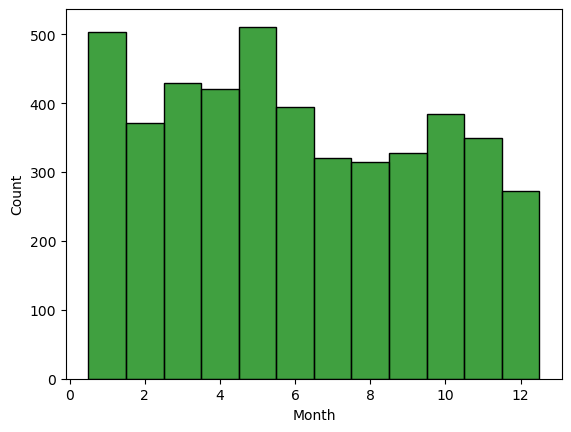

In [21]:
file['Month'] = file['Release Date'].dt.month
sns.histplot(data=file, x="Month", color='green', discrete=True)

<Axes: xlabel='Track Score'>

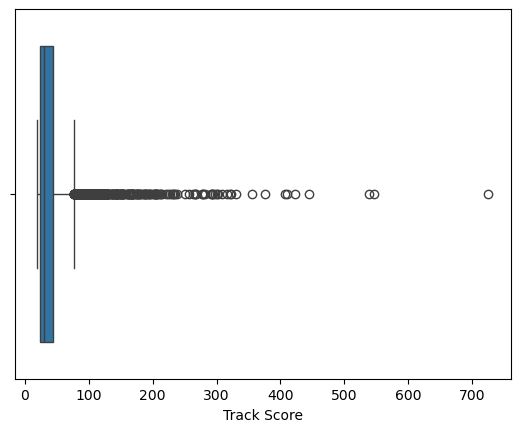

In [22]:
sns.boxplot(data=file, x="Track Score")

In [23]:
numeric_df = file.select_dtypes(include=['float64','int32','int64'])
numeric_df.corr()

,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,TikTok Likes,...,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Year,Month
All Time Rank,1.000000,-0.633577,-0.287332,-0.246276,-0.376643,-0.213832,-0.224678,-0.255756,-0.199128,-0.098058,...,-0.279109,-0.256133,-0.377890,-0.095481,-0.095081,-0.117332,-0.161278,NaN,-0.109557,0.005802
Track Score,-0.633577,1.000000,0.244176,0.187880,0.494119,0.192808,0.194812,0.209678,0.223876,0.094624,...,0.310285,0.475559,0.487969,0.054406,0.076064,0.080265,0.119933,NaN,0.126693,-0.031149
Spotify Streams,-0.287332,0.244176,1.000000,0.798058,0.580030,0.363172,0.417307,0.512749,0.061214,0.057028,...,0.620392,0.073915,0.465277,0.545221,0.363738,0.184727,0.403285,NaN,-0.556165,-0.049758
Spotify Playlist Count,-0.246276,0.187880,0.798058,1.000000,0.615155,0.390837,0.332181,0.436095,0.074708,0.081243,...,0.593739,0.044507,0.456591,0.527183,0.354489,0.233822,0.425686,NaN,-0.614732,-0.043691
Spotify Playlist Reach,-0.376643,0.494119,0.580030,0.615155,1.000000,0.477630,0.206804,0.267279,0.017336,0.046145,...,0.648675,0.507963,0.728159,0.352917,0.234557,0.070704,0.302086,NaN,-0.296902,-0.095409
Spotify Popularity,-0.213832,0.192808,0.363172,0.390837,0.477630,1.000000,0.054890,0.127294,-0.120743,-0.026661,...,0.266785,0.223717,0.366778,0.185985,0.102077,0.054268,0.247096,NaN,-0.142739,-0.027578
YouTube Views,-0.224678,0.194812,0.417307,0.332181,0.206804,0.054890,1.000000,0.835059,0.049627,0.008978,...,0.347845,-0.032049,0.196064,0.323947,0.349260,0.032085,0.231263,NaN,-0.507692,-0.031784
YouTube Likes,-0.255756,0.209678,0.512749,0.436095,0.267279,0.127294,0.835059,1.000000,0.102392,0.056901,...,0.408826,-0.017412,0.252850,0.311510,0.325001,0.074831,0.267210,NaN,-0.472321,-0.026161
TikTok Posts,-0.199128,0.223876,0.061214,0.074708,0.017336,-0.120743,0.049627,0.102392,1.000000,0.513097,...,0.092432,-0.007245,0.022029,0.003971,0.054535,-0.001511,0.062670,NaN,-0.132714,-0.004952
TikTok Likes,-0.098058,0.094624,0.057028,0.081243,0.046145,-0.026661,0.008978,0.056901,0.513097,1.000000,...,0.053095,0.009892,0.048529,-0.004600,0.011850,-0.003037,0.037347,NaN,-0.106876,-0.007688


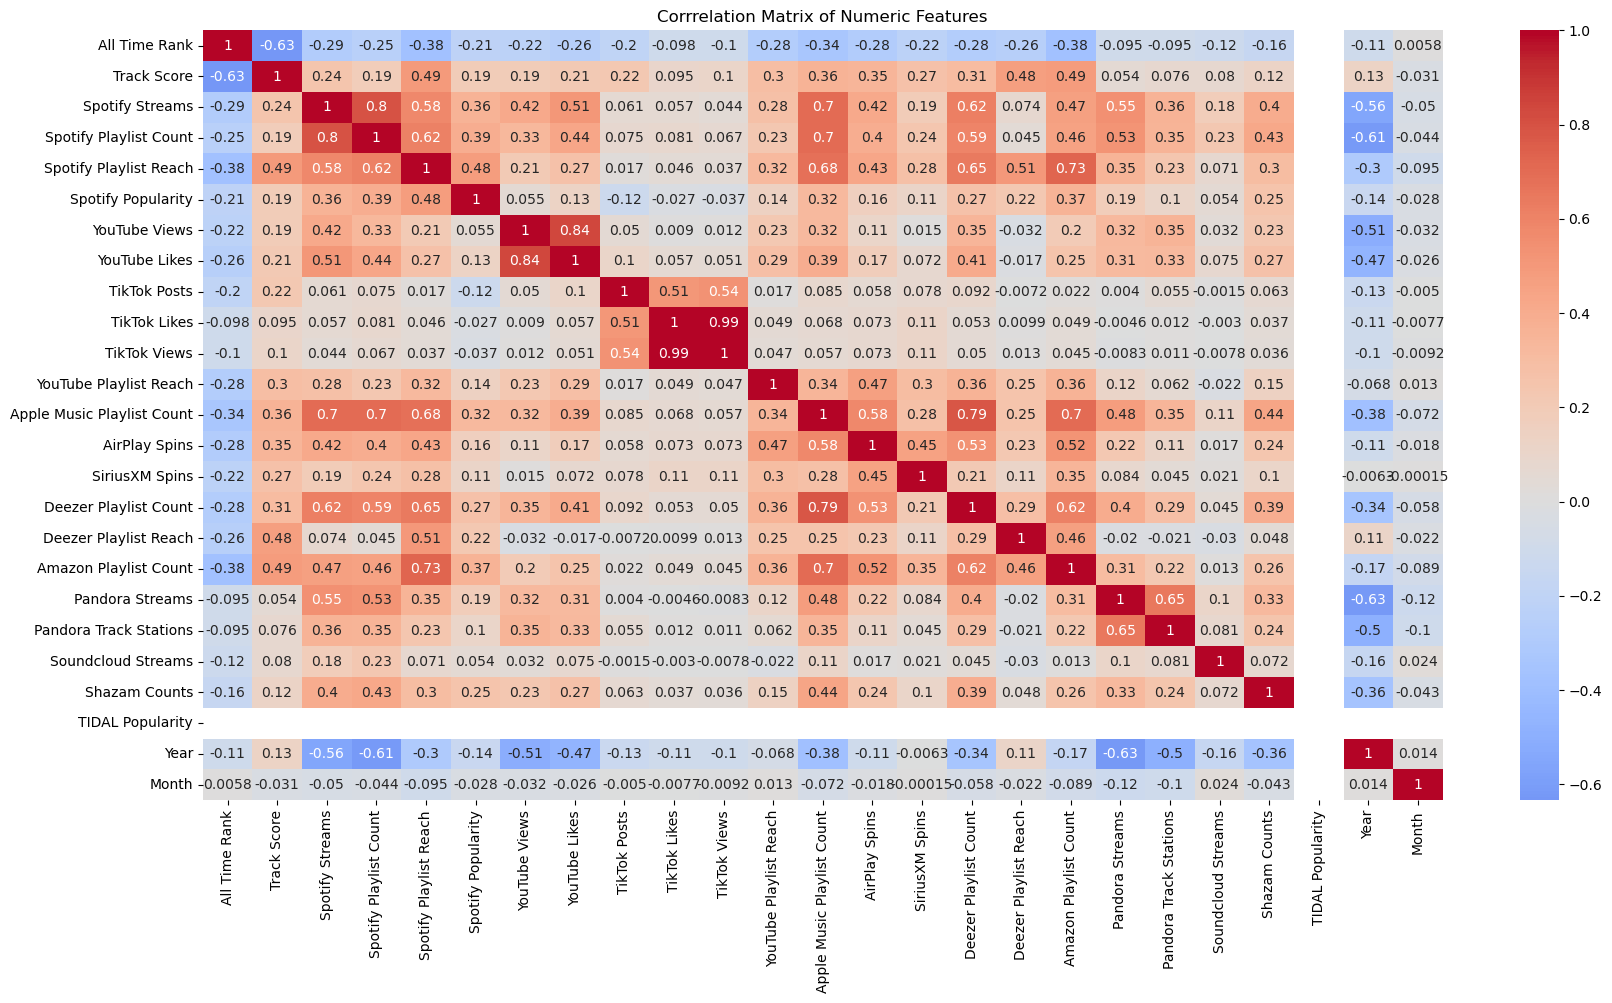

In [24]:
plt.figure(figsize=(20,10))
sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Corrrelation Matrix of Numeric Features')
plt.show()

In [86]:
pd.pivot_table(file.head(50), index='Track', columns='Year', values='Track Score', aggfunc='sum')

Year,2015,2017,2019,2021,2022,2023,2024
Track,,,,,,,
A Bar Song (Tipsy),NaN,NaN,NaN,NaN,NaN,NaN,226.4
As It Was,NaN,NaN,NaN,NaN,292.0,NaN,NaN
BAND4BAND (feat. Lil Baby),NaN,NaN,NaN,NaN,NaN,NaN,330.6
BIRDS OF A FEATHER,NaN,NaN,NaN,NaN,NaN,NaN,212.8
BLUE,NaN,NaN,NaN,NaN,NaN,NaN,292.6
Baby Shark,265.7,NaN,NaN,NaN,NaN,NaN,NaN
Beat Automotivo Tan Tan Tan Viral,NaN,NaN,NaN,NaN,268.1,NaN,NaN
Beautiful Things,NaN,NaN,NaN,NaN,NaN,NaN,407.2
Cupid ï¿½ï¿½ï¿½ Twin Ver. (FIFTY FIFTY) ï¿½ï¿½ï¿½ Spe,NaN,NaN,NaN,NaN,NaN,211.2,NaN


In [94]:
pivot = pd.pivot_table(file.head(50), index='Artist', columns='Year', values='Track Score', aggfunc='sum')

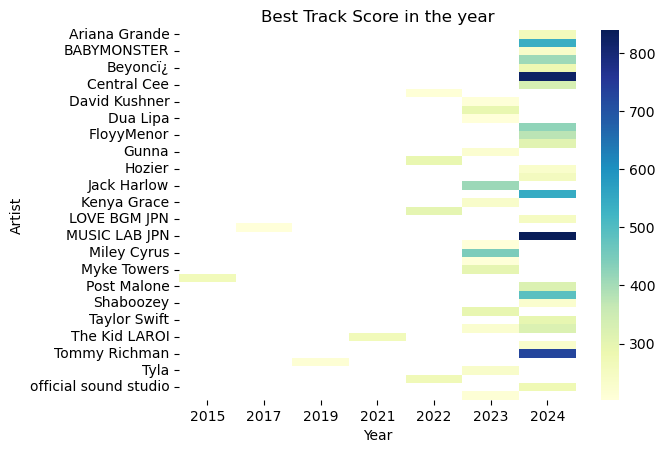

In [96]:
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Best Track Score in the year')
plt.show()

In [98]:
import random

In [116]:
for i in range(19):
    print(file['Artist'][random.randint(1,4600)])

Peso Pluma
Charli xcx
MEDUZA
Lil Big Stack
Rod Wave
Julianno Sosa
Drake
Taylor Swift
Ana Mena
Cris Mj
SleazyWorld Go
Wiz Khalifa
BANNERS
Marca MP
Morgan Wallen
Misael De La Rosa
B Praak
Linkin Park
BARATO NATION
